# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run setup_environment.py
%run ml_tools.py
%run custom_tools.py
%run Selene_Job.ipy

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [14]:
import sys
sys.path.append('/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages')
sys.path

## Get the data

In [2]:
# get raw data
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

In [3]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [4]:
# create the is_somatic class
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)
label_feature_name = 'is_somatic'

In [5]:
# select data
impact_selected = pd.concat([impact[~impact.is_somatic],
                             impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)
impact_selected.shape

(27199, 64)

In [6]:
# choose features
feature_names = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
                 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
                 'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
                 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
                 'gene_type', label_feature_name]
impact_selected = impact_selected[feature_names].dropna()
    
# transform categorical features
categorical_features_names = [ 'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
impact_selected = pd.get_dummies(impact_selected, columns = categorical_features_names, sparse = True)
    
    
X = impact_selected.drop(label_feature_name, axis = 1)
y = impact_selected[label_feature_name]

In [7]:
X = impact_selected.drop(label_feature_name, axis = 1) # X: features matrix [n_samples, n_features]
y = impact_selected[label_feature_name]                # y: target array [n_samples]
print(X.shape)
print(y.shape)

(27199, 45)
(27199,)


In [8]:
get_table(y)

,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [10]:
from sklearn.model_selection import GridSearchCV

# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

In [11]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "  → train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "  → test_index  (%5d elements) %s" % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
   → train_index (21759 elements) [22384  9014  2951 ... 12325  1992 23421]
   → test_index  ( 5440 elements) [25681   326  3615 ...  8464 16587 15818]
Fold 1 :
   → train_index (21759 elements) [ 8628 18579  1037 ... 20352  6647 17410]
   → test_index  ( 5440 elements) [20063 12561 14191 ...  4164   710 20468]
Fold 2 :
   → train_index (21759 elements) [ 1441 21283 25746 ... 17064 10776  1673]
   → test_index  ( 5440 elements) [ 7412 17231 19251 ... 23327 12897  1196]
Fold 3 :
   → train_index (21759 elements) [16914 18024 19701 ...  7224 10318 20742]
   → test_index  ( 5440 elements) [  480  6279 17232 ...  6841 17050  9946]
Fold 4 :
   → train_index (21759 elements) [  141  3724  7643 ...  9259 10806 12796]
   → test_index  ( 5440 elements) [23573 25413 16572 ... 21823  5713  2985]


## Dummy

### Uniform


## Mean accuracy: 0.50 ± 0.01
## Mean ROC AUC : 0.50 ± 0.00


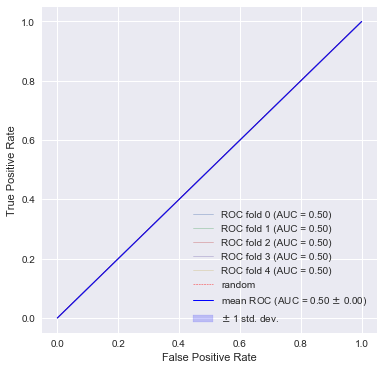

In [13]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
# generates predictions uniformly at random
#   → expected accuracy: 0.5 | expected AUC: 0.5

metrics = run_model(model_uniform, X, y, cv_strategy)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

### Most Frequent


## Mean accuracy: 0.74 ± 0.00
## Mean ROC AUC : 0.50 ± 0.00


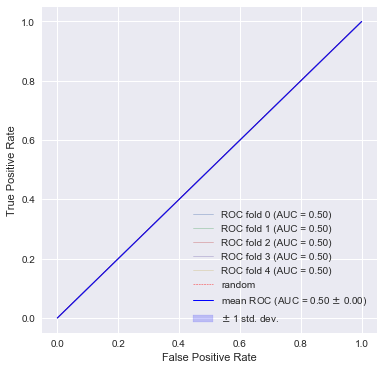

In [14]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

metrics = run_model(model_most_frequent, X, y, cv_strategy)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

## Gaussian Naive Bayes


## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


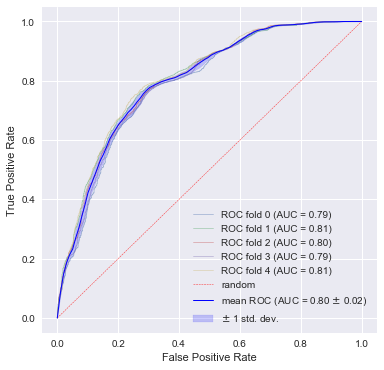

In [15]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

metrics = run_model(model_GaussianNB, X, y, cv_strategy)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

In [22]:
#from sklearn.naive_bayes import ComplementNB

#model_ComplementNB = ComplementNB()

#fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#run(model_ComplementNB, X, y, cv_strategy, plot_roc = True, ax = ax)

## Logistic Regression


## Mean accuracy: 0.84 ± 0.01
## Mean ROC AUC : 0.83 ± 0.01


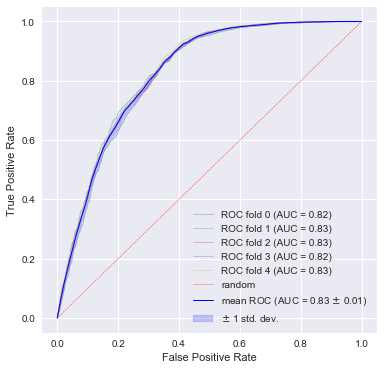

In [16]:
from sklearn.linear_model import LogisticRegressionCV

model_LogisticRegressionCV = LogisticRegressionCV(random_state = 1)
# Logistic Regression with builtin cross-validation to find out the optimal C parameter

metrics = run_model(model_LogisticRegressionCV, X, y, cv_strategy)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), metrics, ax)

## K Nearest Neighbors

In [35]:
job = Selene_Job('somatic_KNN', 'guilminp')
X.to_pickle(job.local_job_directory_path + '/X.pkl')
y.to_pickle(job.local_job_directory_path + '/y.pkl')

➞ mkdir ssh_remote_jobs/job_somatic_KNN


In [36]:
%%writefile {job.local_job_directory_path}/script.py
print("Setup environment...", end = "")
import sys
sys.path.append("../../")
from ml_tools import *
print(" done!")


print("Run model...")
# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# choose a cross-validation strategy
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

from sklearn.model_selection import GridSearchCV
# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

# choose a model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']}
]

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

# run the model
metrics = run_model(model_GS_KNeighborsClassifier, X, y, cv_strategy, print_fold_metrics = True, grid_search = True, print_grid_search_metrics = True)
print(" done!")


print("Save metrics...", end = "")
metrics.to_pickle("metrics.pkl")
print(" done!")

Writing ssh_remote_jobs/job_somatic_KNN/script.py


In [37]:
job.run()

➞ scp ssh_remote_jobs/job_somatic_KNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
X.pkl                                         100% 5266KB   8.6MB/s   00:00    
y.pkl                                         100%  452KB   6.1MB/s   00:00    
script.py                                     100% 1237    53.7KB/s   00:00    
➞ Logged in /home/guilminp on selene.cbio.private
➞ Load ~/.bash_profile
Hi Pierre!
➞ Work on impact-annotator_env python virtualenv
➞ Launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_somatic_KNN
Job <28111639> is submitted to default queue <sol>.


✅ <span style='color:green'>Job \< somatic_KNN \> finished !</span><br>

➞ scp guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_somatic_KNN documents to ssh_remote_jobs/job_somatic_KNN
metrics.pkl                                   100%  121KB   3.8MB/s   00:00    
job_output.txt                                100% 4271   733.7KB/s   00:00    
➞ Load metrics.pkl in pandas dataframe
## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.78 ± 0.01


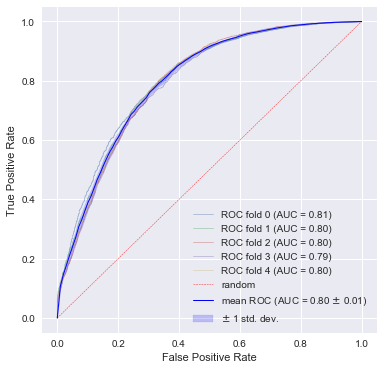

In [40]:
job.get_results()
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
plot_roc(cv_strategy.get_n_splits(), job.metrics, ax)

## Random Forest

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [301.90s | 7.01s]
  → accuracy: [0.89 | 1.00]
  → ROC AUC : [0.89 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.85 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.86 ± 0.00 for {'max_depth': 5, 'n_estimators': 1000}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 20, 'n_estimators': 1000}
    0.88 ± 0.01 for {'max_depth': 50, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 50, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 50, 'n_estimators': 1000}
Fold 1: [311.69s | 4.70s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.90 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 1000}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,301.899,7.00568,1,0.8875,1,0.894499,"{'max_depth': 50, 'n_estimators': 1000}"
1,311.694,4.70313,0.928949,0.880331,0.964923,0.903131,"{'max_depth': 20, 'n_estimators': 1000}"
2,313.319,7.27124,0.928122,0.879963,0.965306,0.891553,"{'max_depth': 20, 'n_estimators': 1000}"
3,409.016,11.0728,1,0.884559,1,0.892541,"{'max_depth': 50, 'n_estimators': 1000}"
4,361.309,7.69033,1,0.887132,1,0.896806,"{'max_depth': 50, 'n_estimators': 1000}"


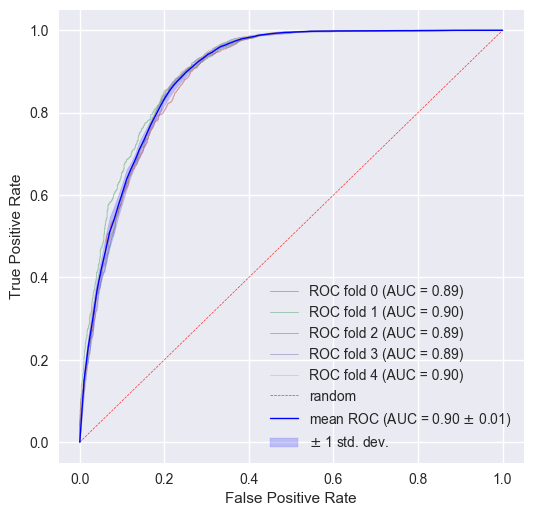

In [25]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.82 ± 0.01
## Mean ROC AUC : 0.77 ± 0.01


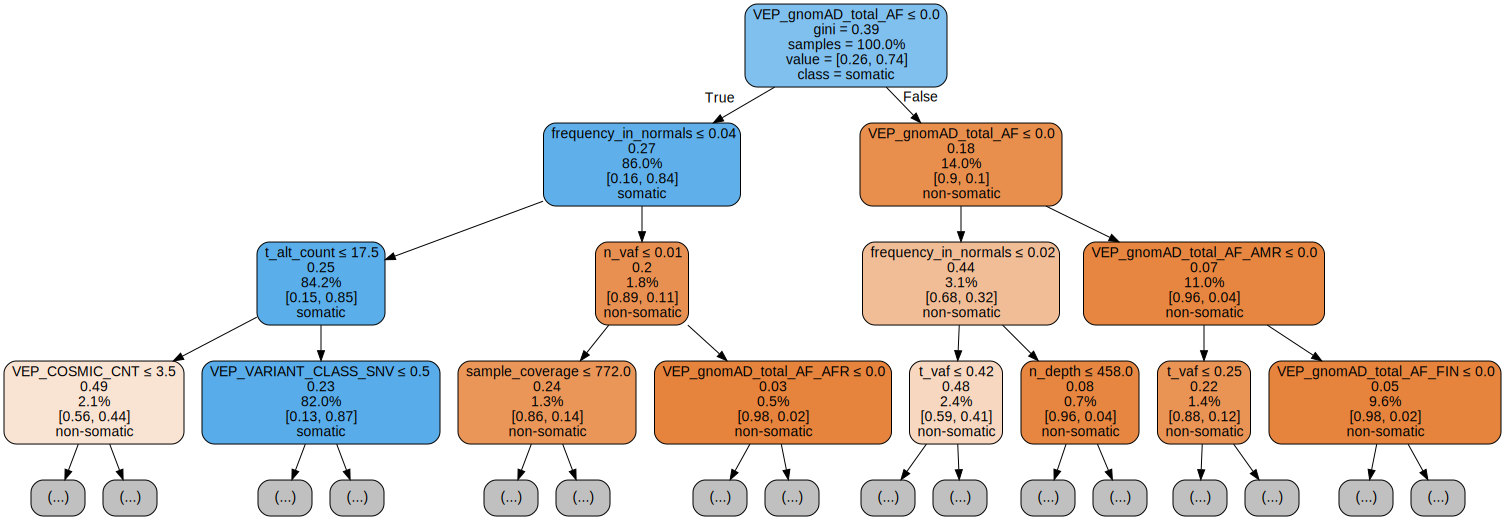

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 1)
run_model(model_DecisionTreeClassifier, X, y, cv_strategy)

model_DecisionTreeClassifier.fit(X, y)
dot_data = export_graphviz(model_DecisionTreeClassifier, out_file = None, max_depth = 3, feature_names = X.columns.tolist(), class_names = ['non-somatic', 'somatic'], label = 'root', filled = True, proportion = True, rounded = True, special_characters = True, precision = 2) 
graph = graphviz.Source(dot_data) 
graph

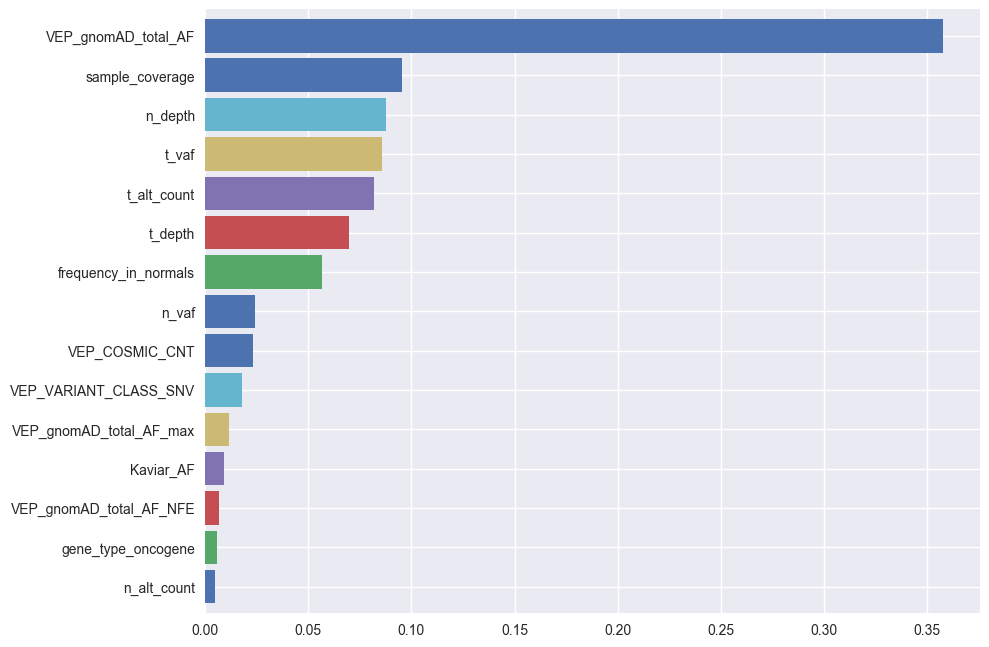

In [27]:
feature_importance = pd.Series(model_DecisionTreeClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


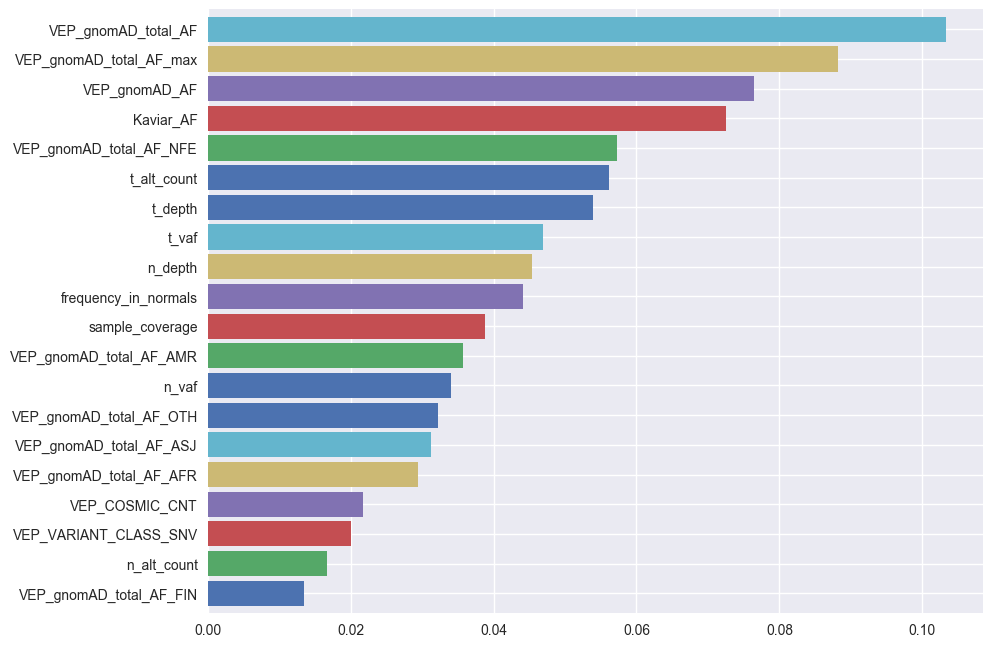

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 20)
run_model(model_best_RandomForestClassifier, X, y, cv_strategy)

model_best_RandomForestClassifier.fit(X, y)

feature_importance = pd.Series(model_best_RandomForestClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(20)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Gradient Boosting

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [34.91s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.88 | 0.90]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.82 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.84 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.88 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 100}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 10}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 100}
Fold 1: [34.75s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.90 | 0.89]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.83 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.85 ± 0.01 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.8

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,34.9126,0.0791869,0.882118,0.880331,0.896267,0.882781,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,34.751,0.0789692,0.882991,0.880147,0.89475,0.895432,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,34.4062,0.0763741,0.883083,0.879596,0.896355,0.880396,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,35.1259,0.0756898,0.884002,0.879596,0.896101,0.886436,"{'learning_rate': 0.1, 'n_estimators': 100}"
4,33.4458,0.0784383,0.882348,0.881801,0.89522,0.889147,"{'learning_rate': 0.1, 'n_estimators': 100}"


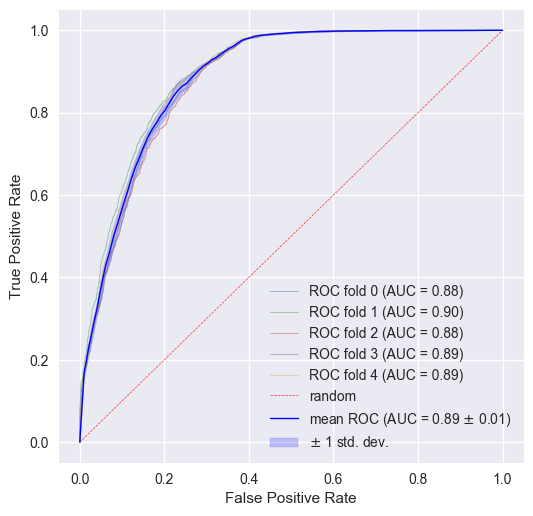

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100]}
]

model_GS_GradientBoostingClassifier = GridSearchCV(GradientBoostingClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_GradientBoostingClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


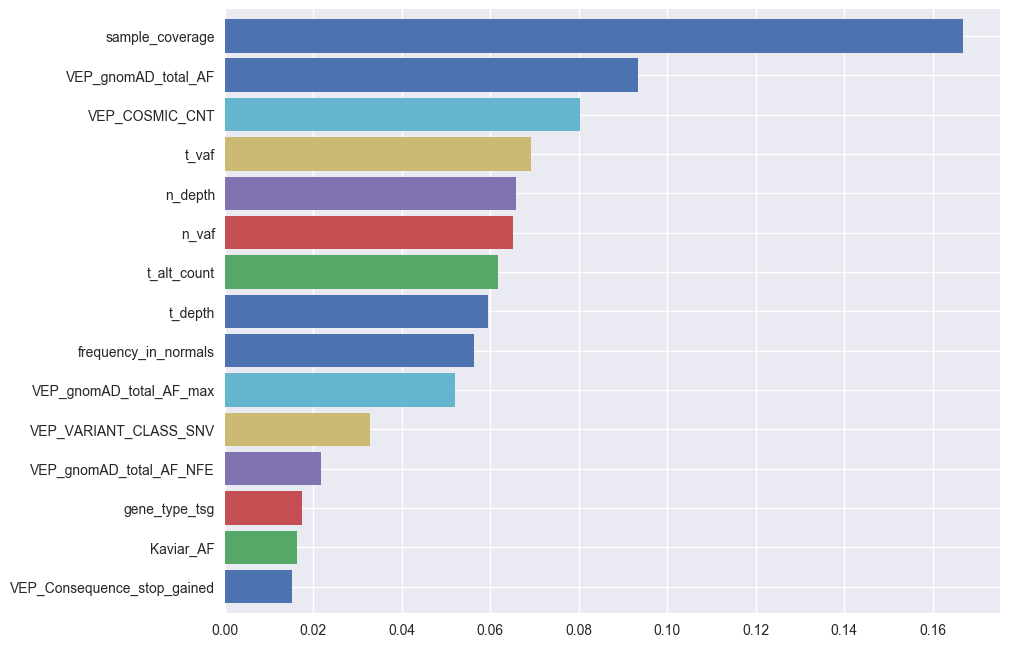

In [30]:
model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state = 1, learning_rate = 0.1, n_estimators = 100)
run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy)

model_best_GradientBoostingClassifier.fit(X, y)

feature_importance = pd.Series(model_best_GradientBoostingClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = False, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Cluster test


## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


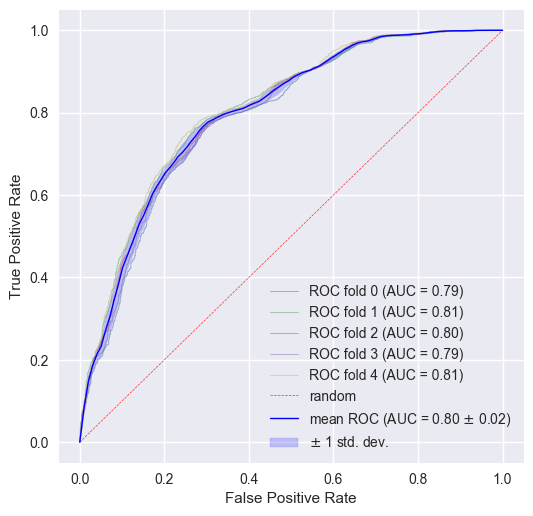

In [20]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
metrics = run_model(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [21]:
metrics

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.119909,0.050761,0.797739,0.799816,0.79922,0.788132,NaN
1,0.0875502,0.0582831,0.795119,0.795404,0.798381,0.806598,NaN
2,0.09376,0.065176,0.793511,0.79761,0.79502,0.799848,NaN
3,0.140888,0.129509,0.796498,0.800735,0.796747,0.793025,NaN
4,0.152683,0.0916238,0.79875,0.807169,0.798306,0.80942,NaN


In [261]:
class Selene_Job:
    def __init__(self, job_id):
        self.job_id = job_id
        self.local_job_directory_path = 'ssh_remote_jobs/job_' + str(job_id)
        self.selene_ssh_remote_jobs_path = 'guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs'
        self.selene_job_directory_path = self.selene_ssh_remote_jobs_path + '/job_' + str(job_id)
        
        self.make_local_job_directory_()
        
    def make_local_job_directory_(self):
        print('➞ mkdir ' + self.local_job_directory_path)
        ! mkdir {self.local_job_directory_path}
    
    def run(self):
        print('➞ scp ' + self.local_job_directory_path + ' to ' + self.selene_ssh_remote_jobs_path)
        ! scp -r {self.local_job_directory_path} {self.selene_ssh_remote_jobs_path}

        test = 'echo "➞ Logged in $PWD on $HOSTNAME"; \
                \
                echo "➞ Load ~/.bash_profile"; \
                source ~/.bash_profile; \
                export LSF_ENVDIR=/common/lsf/conf; export LSF_SERVERDIR=/common/lsf/9.1/linux2.6-glibc2.3-x86_64/etc; \
                \
                echo "➞ Work on impact-annotator_env python virtualenv"; \
                workon impact-annotator_env; \
                \
                cd ~/impact-annotator/analysis/prediction/ssh_remote_jobs/job_' + str(self.job_id) + '; \
                echo "➞ Launch job in $PWD"; \
                bsub -o job_output.txt -We 2 "python script.py"'

        ! ssh guilminp@selene.mskcc.org '{test}'
    
    def get_results(self):        
        test = 'cd ~/impact-annotator/analysis/prediction/ssh_remote_jobs/job_' + str(self.job_id) + '; \
               [ -e metrics.csv ] && echo "yes" || echo "no"'
            
        file_found = ! ssh guilminp@selene.mskcc.org '{test}'
        file_found = file_found[0]

        if file_found == "yes":
            print_md("✅ <span style='color:green'>Job \< " + str(self.job_id) + " \> finished !</span>\n")
            print('➞ scp ' + self.selene_job_directory_path + ' documents to ' + self.local_job_directory_path)
            ! scp -r {self.selene_job_directory_path}/metrics.csv {self.local_job_directory_path}
            ! scp -r {self.selene_job_directory_path}/job_output.txt {self.local_job_directory_path}
            print('➞ Load metrics.csv in pandas dataframe')
            self.metrics = pd.read_csv(self.local_job_directory_path + '/metrics.csv', sep = ',', low_memory = False)
            
            return(self.metrics)
        else:
            print_md("⚠️ <span style='color:red'>Job \< " + str(self.job_id) + " \> doesn't exist or is not done yet.</span>\n")

In [262]:
job_final_test = Selene_Job("final_test")

➞ mkdir ssh_remote_jobs/job_final_test
mkdir: ssh_remote_jobs/job_final_test: File exists


In [263]:
%%writefile {job_final_test.local_job_directory_path}/script.py
print("Setup environment...", end = "")
import sys
sys.path.append("../../")

from ml_tools import *
print(" done!")

print("Run model...")
from sklearn.model_selection import StratifiedShuffleSplit
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()
X, y = load_dataset("../../../../data")
metrics = run_model(model_GaussianNB, X, y, cv_strategy, print_fold_metrics = True, in_cluster = True)

print("Save metrics...", end = "")
metrics.to_csv("metrics.csv")
print(" done!")

Overwriting ssh_remote_jobs/job_final_test/script.py


In [264]:
job_final_test.run()

➞ scp ssh_remote_jobs/job_final_test to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
metrics.csv                                   100%  699     5.7KB/s   00:00    
job_output.txt                                100% 1998    57.0KB/s   00:00    
script.py                                     100%  433     4.9KB/s   00:00    
➞ Logged in /home/guilminp on selene.cbio.private
➞ Load ~/.bash_profile
Hi Pierre!
➞ Work on impact-annotator_env python virtualenv
➞ Launch job in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_final_test
Job <28052793> is submitted to default queue <sol>.


In [267]:
job_final_test.get_results()

✅ <span style='color:green'>Job \< final_test \> finished !</span><br>

➞ scp guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_final_test documents to ssh_remote_jobs/job_final_test
metrics.csv                                   100% 1349   343.7KB/s   00:00    
job_output.txt                                100% 3838   835.5KB/s   00:00    
➞ Load metrics.csv in pandas dataframe


,fold_number,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,test_fpr,test_tpr,best_parameters
0,0,0.048537,0.030360,0.797739,0.799816,0.799220,0.788132,[0. 0.00138889 0.00208333 ... 0.93333333 0.98125 1. ],[0. 0.036 0.03625 ... 1. 1. 1. ],NaN
1,1,0.046053,0.030301,0.795119,0.795404,0.798381,0.806598,[0. 0.00277778 0.00347222 ... 0.96319444 0.98055556 1. ],[0. 0.03825 0.03825 ... 1. 1. 1. ],NaN
2,2,0.047653,0.030849,0.793511,0.797610,0.795020,0.799848,[0. 0.00416667 0.00416667 ... 0.92986111 0.98125 1. ],[0. 0.04 0.04075 ... 1. 1. 1. ],NaN
3,3,0.047003,0.029794,0.796498,0.800735,0.796747,0.793025,[0. 0.00416667 0.00416667 ... 0.9625 0.975 1. ],[0. 0.04775 0.04875 ... 1. 1. 1. ],NaN
4,4,0.047501,0.030154,0.798750,0.807169,0.798306,0.809420,[0. 0.00347222 0.00347222 ... 0.93333333 0.97708333 1. ],[0. 0.03925 0.04 ... 1. 1. 1. ],NaN


## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting